In [1]:
import os
import json 

current_working_directory = os.getcwd()
print(f"La directory di lavoro corrente è: {current_working_directory}")


file_name = 'ES951_error_dict.json'

print(f"Tentativo di aprire il file: {file_name}")
print(f"Directory di lavoro corrente: {os.getcwd()}")
print(f"Il file esiste a questo percorso? {os.path.exists(file_name)}")

try:
    with open(file_name, 'r') as f:
        data = json.load(f)
        print("File aperto con successo!")
except FileNotFoundError:
    print(f"Errore: Il file '{file_name}' non è stato trovato.")
    print("Controlla il percorso del file e la directory di lavoro corrente.")
except Exception as e:
    print(f"Si è verificato un errore inatteso: {e}")

La directory di lavoro corrente è: /home/gueststudente/tesivalerio/Tesi
Tentativo di aprire il file: ES951_error_dict.json
Directory di lavoro corrente: /home/gueststudente/tesivalerio/Tesi
Il file esiste a questo percorso? True
File aperto con successo!


In [2]:
#pip install openpyxl matplotlib tensorflow numpy pandas seaborn stumpy nptdms plotly tqdm darts scikit-learn nbformat ipykernel jupyter icecream mlflow -q

In [3]:
import os
import shutil
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import statistics
from icecream import ic
import stumpy
import random
from nptdms import TdmsFile
from nptdms import tdms
from pprint import pprint
from tqdm import tqdm
import json
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import requests
import mlflow

from collections import defaultdict

from IPython.display import SVG, display

2025-10-20 12:23:50.688030: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760955830.720889  903273 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760955830.731645  903273 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1760955830.798178  903273 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760955830.798186  903273 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1760955830.798188  903273 computation_placer.cc:177] computation placer alr

In [4]:
import torch

In [5]:
import darts

In [6]:
# Take tdms file_name list and returns a dataframe list of their 'Raw Data'

def load_tdms_data(file_names, write=False, max = -1):
    dataframe_list = []
    for file in tqdm(file_names):
        if max != -1:
            if len(dataframe_list) >= max:
                break
        tdms_file = TdmsFile.read(file)
        group = tdms_file["Raw Data"]
        df = group.as_dataframe()
        dataframe_list.append(df)
        # print('SN: ', file.strip('_'))
        if write:
            file = file.replace(".tdms", "")
            df.to_excel(str(file)+".xlsx")
    return dataframe_list

In [7]:
# Create ts_dict which has the structure:
# ts_dict = {
#     'ts_aggregated_step_1' : [ts_list_step_1],
#     'ts_aggregated_step_2' : [ts_list_step_2],
#      ....
# }

def ts_dict_attr_per_step(df_list, attribute, spindle_type='ES951', append_nan=True):
    ts_dict = {}
    match spindle_type:
        case 'Aggregato':
            steps = 5
        case 'ES951':
            steps = 8
        case _ :
            return
        
    for index, df in enumerate(df_list):
        for step in range(1, steps+1):
            variable_name = f"ts_aggregated_step_{step}"
            df_step = df[df['Step'] == step]

            attr = np.array(df_step[attribute])
            if append_nan:
                attr = np.append(attr, np.nan)
            try:
                # ts_dict[variable_name].append(norm_temp)
                ts_dict[variable_name].append(attr)
            except:
                ts_dict[variable_name] = []
                # ts_dict[variable_name].append(norm_temp)
                ts_dict[variable_name].append(attr)
    return ts_dict

In [8]:
# Plot "traces_to_visualize" traces representing a specific attribute of the ts_list, for a specific step

def plot_attr_step(df_list, attribute, step='all', spindle_type='ES951', traces_to_visualize='all', consensus_motif=None):

    fig = go.Figure()

    longest_df = max([x for x in df_list], key=len)

    
    if isinstance(step, int):
        ts_dict = ts_dict_attr_per_step(df_list, attribute, spindle_type, False)
        ts_list = ts_dict['ts_aggregated_step_' + str(step)]
        fig.add_trace(go.Scatter(y=longest_df[longest_df['Step'] == step]['Speed_S3_BUS']/250, mode='lines', line=dict(dash='dash'), name='Speed_S3_BUS'))
    
    else: # all steps
        
        ts_list = []
        for df in df_list:
            ts_list.append(df[attribute])
        
        fig.add_trace(go.Scatter(y=longest_df['Step']*10, mode='lines', line=dict(dash='dash'), name='Step'))
        fig.add_trace(go.Scatter(y=longest_df['Speed_S3_BUS']/250, mode='lines', line=dict(dash='dash'), name='Speed_S3_BUS'))
    

    match traces_to_visualize:
        case 'all':
            traces_to_visualize = len(ts_list)
        case int():
            pass
        case _ : 
            print('traces_to_visualize must be either the string "all" or an integer value.')
        
    
    if consensus_motif is not None:
        fig.add_trace(go.Scatter(y=consensus_motif, mode='lines', line={'width': 4}, name='Consensus Motif'))


    for i in range(traces_to_visualize):
        try:
            ts = ts_list[i]
            fig.add_trace(go.Scatter(y=ts, mode='lines', name='trace ' + str(i)))
        except:
            print('Out of range, displaying ', i , ' plots.')
            break
        
    fig.update_layout(
        title='SPINDLE: ' + spindle_type + '\t\t\tSTEP: ' + str(step) + '\t\t\tATTRIBUTE: ' + attribute + '\t\t\t# OF TRACES: ' + str(traces_to_visualize)
    )
    fig.show()

In [9]:
def consensus_motif(ts_dict, step, m = None, plot=False):
    Ts = ts_dict['ts_aggregated_step_' + str(step)]
    if m is None:
        m = len(min(Ts, key=len))
    print('m = ', m)
    radius, Ts_idx, subseq_idx = stumpy.ostinato(Ts, m)
    print(f'Found Best Radius {np.round(radius, 2)} in time series {Ts_idx} starting at subsequence index location {subseq_idx}.')
    consensus_motif = Ts[Ts_idx][subseq_idx : subseq_idx + m]
    nn_idx = []
    fig = go.Figure()
    for i, T in enumerate(Ts):
        nn_idx.append(np.argmin(stumpy.core.mass(consensus_motif, T)))
        lw = 1
        label = None
        if i == Ts_idx:
            lw = 5
            label = 'Consensus Motif'
        fig.add_trace(go.Scatter(y=T[nn_idx[i] : nn_idx[i]+m], line={'width':lw}, name=label))


    # Show the plot
    if plot:
        fig.update_layout(
            title = 'Consensus Motif - STEP: ' + str(step) + ''
        )
        fig.show()
    return consensus_motif

In [10]:
# Create a list of dict which has the structure:
# err_list = [... {
#     'Count' : 1,
#     'Error' : 'Errore flussostato chiller',
#     'Error Code' : 8134,
#     'tdms_dict' : {
#           'step 1' : [H2492598201 AM, H25244902 PM, ...],
#           'step 2' : [...], 
#           ...
#      }
#      
# } 
# ... ]

def distribution_error_dict(spindle_type='ES951', plot=True):
    match spindle_type:
        case 'Aggregato':
            error_dict = 'aggregati_error_dict.json'
            steps = 5
        case 'ES951':
            error_dict = 'ES951_error_dict.json'
            steps = 8
        case _:
            print('Insert either type "Aggregato" or "ES951"')
            return
    
    with open(error_dict) as json_file:
        data = json.load(json_file)
    
    unique_errors = {(x['Error Code'], x['Error'].split('\n')[4]) for x in data.values()}
    error_counts = defaultdict(int)
    for elem in data.values():
        error_counts[elem['Error Code']] += 1

    error_check = [{'Error Code': elem[0], 'Error': elem[1], 'Count': error_counts[elem[0]]} for elem in unique_errors]


    for x in error_check:
        x['tdms_dict'] = {}
        for step in range(steps+1):
            tmp_step = 'step ' + str(step)
            x['tdms_dict'][tmp_step] = [y for y in data if data[y]['Error Code'] == x['Error Code'] 
                                                   and data[y]['Failing Step'] == step]
            if x['tdms_dict'][tmp_step] == []:
                x['tdms_dict'].pop(tmp_step)
    

    if plot:
        print('----------------> Error Distribution Over Spindles Type "', spindle_type, '"\n')
        pprint(error_check)

    return error_check

In [11]:
# Take error_code (and optionally step) as input and returns all the breakins

def df_list_from_err_dict(error_code, step=None, spindle_type='ES951'):
    err_list = distribution_error_dict(spindle_type, plot=False)
    base_path_es951_failed = 'splitted_tdms/ES951/Fail/'
    f = lambda str : os.path.join(base_path_es951_failed, str + '.tdms')

    file_names = []
    for s in range(10):
        try:
            file_names.append(list(map(f, [x['tdms_dict']['step ' + str(step)] for x in err_list if x['Error Code'] == error_code][0])))
        except KeyError:
            continue

    file_names = [item for sublist in file_names for item in sublist]

    if step is not None and isinstance(step, int):
        try: 
            file_names = list(map(f, [x['tdms_dict']['step ' + str(step)] for x in err_list if x['Error Code'] == error_code][0]))
        except KeyError as err:
            print(err)
            return None

    return load_tdms_data(file_names)

In [12]:
#print(df_fail_breakin_es951)

In [13]:
attr_dict = {
    1 : 'Speed_S3_BUS',
    2 : 'Itot',
    3 : 'Tamb',
    4 : 'Tba',
    5 : 'NHR',
    6 : 'Tdut1',
    7 : 'Tdut2',
    8 : 'Tdut3',
    9 : 'Vib_EM',
    10 : 'Vib_AGG_Lato',
    11 : 'Vib_AGG_Fondo',
    12 : 'Noise_dbA'
}

#success_breakin_aggregato = glob.glob('Log aggregati/*.tdms')
success_breakin_es951 = glob.glob('splitted_tdms/ES951/Success/*.tdms')
#fail_breakin_aggregato = glob.glob('tdms/wetransfer_fail-rodaggi_2023-10-20_1232/Aggregato/*.tdms')
fail_breakin_es951 = glob.glob('splitted_tdms/ES951/Fail/*.tdms') #questo è il problema! non esiste, ma dove sono gli errori di es951?

#DF LISTS
df_success_breakin_es951 = load_tdms_data(success_breakin_es951)
#df_fail_breakin_aggregato = load_tdms_data(fail_breakin_aggregato)
df_fail_breakin_es951 = load_tdms_data(fail_breakin_es951)


# #df_fail_breakin_vib_lato_dict = {}
# #df_fail_breakin_aggregato_vib_fondo_dict = {}
# df_fail_breakin_es951_vib_ant_dict = {}
# #df_fail_breakin_es951_vib_fondo_dict = {}

# for step in range(6):
#     #df_list_per_step_vib_lato = df_list_from_err_dict(7704,step) #questo dà errore list index out of range
#     #df_list_per_step_vib_fondo = df_list_from_err_dict(7705,step) #questo dà errore list index out of range
#     df_list_per_step_vib_ant = df_list_from_err_dict(7303,step)
#     df_list_per_step_vib_ant = df_list_from_err_dict(7102,step)
#     #df_list_per_step_vib_lato = df_list_from_err_dict(7201,step) #No such file or directory: 'tdms/wetransfer_fail-rodaggi_2023-10-20_1232/ES951/H6161H1234_2022044444_2022.08.29_04.35.09 PM.tdms' 
#     if df_list_per_step_vib_ant is not None:
#         df_fail_breakin_es951_vib_ant_dict['step ' + str(step)] = df_list_per_step_vib_ant      # 'Vibrazione Accelerometro Lato Fuori dai limiti'
#     #if df_list_per_step_vib_fondo is not None:
#     #    df_fail_breakin_es951_vib_fondo_dict['step ' + str(step)] =  df_list_per_step_vib_fondo   # 'Vibrazione Accelerometro Fondo Fuori dai limiti'

100%|██████████| 24/24 [00:00<00:00, 293.56it/s]


In [14]:
# ATTRIBUTE = attr_dict[10]
# STEP = 0 #7?
# DF_LIST = df_fail_breakin_es951_vib_lato_dict
# SPINDLE_TYPE = 'ES951' #'Aggregato'

In [15]:
# error_dict_aggregati = distribution_error_dict(plot=True)
# print('\n')
# error_dict_es951 = distribution_error_dict(spindle_type='ES951', plot=True)

In [16]:
# plot_attr_step(
#     df_list=df_fail_breakin_es951_vib_lato_dict['step ' + str(STEP)],
#     attribute=ATTRIBUTE,
#     step=STEP,
#     traces_to_visualize='all',
#     # consensus_motif=consensus_motif(ts_dict_attr_per_step(df_success_breakin_aggregato, ATTRIBUTE), STEP)
# )
# plot_attr_step(
#     df_list=df_fail_breakin_es951_vib_lato_dict['step ' + str(STEP)],
#     attribute=attr_dict[4],
#     step=STEP,
#     traces_to_visualize=3,
#     # consensus_motif=consensus_motif(ts_dict_attr_per_step(df_success_breakin_aggregato, ATTRIBUTE), STEP)
# )

# plot_attr_step(
#     df_list=df_success_breakin_es951,
#     attribute=attr_dict[4],
#     step=STEP,
#     traces_to_visualize=3,
#     # consensus_motif=consensus_motif(ts_dict_attr_per_step(df_success_breakin_aggregato, ATTRIBUTE), STEP)
# )

# # plot_attr_step(consensus_motif_success_aggregato, ts_dict, step='all', traces_to_visualize='all')

In [17]:
import darts
from darts.models import XGBModel, NBEATSModel, NHiTSModel, TFTModel, TCNModel, TiDEModel, BlockRNNModel, TransformerModel, CatBoostModel, LightGBMModel, RNNModel
from darts import TimeSeries
from sklearn import preprocessing

from darts.dataprocessing import dtw
from darts.dataprocessing.transformers import Scaler
from darts.utils import timeseries_generation as tg
from darts.utils.missing_values import fill_missing_values
from darts.datasets import SunspotsDataset
from darts.metrics import dtw_metric, mae, mape, mse, smape, rmse, mase, ope
from darts.models import MovingAverageFilter
from darts import concatenate
from darts.explainability import TFTExplainabilityResult, TFTExplainer
print(darts.__version__)

0.36.0


In [18]:
df1 = df_success_breakin_es951[0].loc[:, ["Speed_S3_BUS"]]
df2 = df_success_breakin_es951[1].loc[:, ["Speed_S3_BUS"]]

ts1 = TimeSeries.from_dataframe(df1)
ts2 = TimeSeries.from_dataframe(df2)

print(ts1.time_index)
print(ts2.time_index)

print(ts1.columns)
print(type(ts1))

print(ts1.duration)
# ts1.plot()

RangeIndex(start=0, stop=43102, step=1)
RangeIndex(start=0, stop=43170, step=1)
Index(['Speed_S3_BUS'], dtype='object')
<class 'darts.timeseries.TimeSeries'>
43101


In [19]:
def align_df(min, df):
    x =  len(df) - min
    if x > 0:
        return df[:-x]
    return df

In [20]:
df_success_breakin_es951[0].loc[:,"Step"]

0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
43097    8.0
43098    8.0
43099    8.0
43100    8.0
43101    8.0
Name: Step, Length: 43102, dtype: float64

In [21]:
# df_list_success = [df.loc[:, ["Itot", "Tba", #"Vib_AGG_Lato", "Vib_AGG_Fondo",
#                               "Speed_S3_BUS", "Step"]] for df in df_success_breakin_es951]
# df_list_failed = [df.loc[:, ["Itot", "Tba", #"Vib_AGG_Lato", "Vib_AGG_Fondo",
#                              "Speed_S3_BUS", "Step"]] for df in df_fail_breakin_es951]

df_list_success = []
iter = 0
for df in df_success_breakin_es951:
    try:
        df_list_success.append(df.loc[:, ["Itot", "Tba", "Speed_S3_BUS", "Step"]])
    except:
        df_raw = df.loc[:, ["Itot", "Tba", "Velocità", "Step"]]
        df_raw = df_raw.rename(columns={"Velocità":"Speed_S3_BUS"}) 
        df_list_success.append(df_raw)
    iter+=1
print(len(df_list_success))
    
df_list_failed = []
for df in df_fail_breakin_es951:
    try:
        df_list_failed.append(df.loc[:, ["Itot", "Tba", "Speed_S3_BUS", "Step"]])
    except:
        df_raw = df.loc[:, ["Itot", "Tba", "Velocità", "Step"]]
        df_raw = df_raw.rename(columns={"Velocità":"Speed_S3_BUS"}) 
        df_list_failed.append(df_raw)
print(len(df_list_failed))

# df_list_success = [df.loc[:, ["Tba","Tamb"]] for df in df_success_breakin_aggregato]
# df_list_failed = [df.loc[:, ["Tba","Tamb"]] for df in df_fail_breakin_aggregato]

print(df_list_success[0].loc[:,"Step"])
# Find the maximum value for the 'your_column' in each dataframe
for col in df_list_failed[0].columns:

    max_values = [df[col].max() for df in df_list_success]
    min_values = [df[col].min() for df in df_list_success]

    overall_max_value = ic(col, max(max_values))
    overall_min_value = ic(col, min(min_values)) 

# Downsampling (every 1 seconds)

downsampling = 1
df_list_success = [x.iloc[::downsampling] for x in df_list_success]
df_list_failed = [x.iloc[::downsampling] for x in df_list_failed]

# min_len = len(min(df_list_success, key=len))
# align_fun = lambda df : align_df(min_len, df)
# df_list_success = list(map(align_fun, df_list_success))

print("dopo align fun")
ic(len(max(df_list_success, key=len)))
ic(len(min(df_list_success, key=len)))

# Find the overall maximum value across all dataframes
# overall_max_value = max(max_values)
# overall_min_value = min(min_values)
# print(overall_max_value, overall_min_value)

# Select columns with 'float64' dtype  
# float64_cols = list(df_list_success[0].select_dtypes(include='float64'))

# The same code again calling the columns
# df_list_success = [x[float64_cols].astype('float32') for x in df_list_success]
# df_list_failed = [x[float64_cols].astype('float32') for x in df_list_success]



ts_list_success = [TimeSeries.from_dataframe(ts) for ts in df_list_success]
# ts_list_success_speed3 = [TimeSeries.from_dataframe(ts) for ts in df_list_success_speed3]
ts_list_failed = [TimeSeries.from_dataframe(ts) for ts in df_list_failed]
# ts_list_failed_speed3 = [TimeSeries.from_dataframe(ts) for ts in df_list_failed_speed3]


ts_list = ts_list_success + ts_list_failed

ic(len(ts_list))

ts_list = [ts for ts in ts_list if ts.duration > 0]

ic(len(ts_list))

seed = 1
random.seed(seed)
random.shuffle(ts_list_success)

#resample

split_point = int(len(ts_list_success) * 0.8)

train_set, test_set = ts_list_success[:split_point], ts_list_success[split_point:]



scaler = preprocessing.MinMaxScaler((0,1), clip=True)
train_scaler = Scaler(scaler, global_fit=True)
train = train_scaler.fit_transform(train_set) #serie training target scalata
test = train_scaler.transform(test_set) #serie test target scalata

train_speed3 = [ts['Speed_S3_BUS'] for ts in train] #serie training covariata
test_speed3 = [ts['Speed_S3_BUS'] for ts in test] #serie test covariata

train_step = [ts['Step'] for ts in train]
test_step = [ts['Step'] for ts in test]

train = [ts.drop_columns(['Speed_S3_BUS', 'Step']) for ts in train]
test = [ts.drop_columns(['Speed_S3_BUS', 'Step']) for ts in test]

max_len_train = ic(len(max(train, key=len)))
min_len_train = ic(len(min(train, key=len)))

max_len_test = ic(len(max(test, key=len)))
min_len_test = ic(len(min(test, key=len)))


# train, val = [x.split_after(0.7)[0] for x in ts_list_success_pre], [x.split_after(0.7)[1] for x in ts_list_success_pre]
# past_cov, future_cov = [x.split_after(0.7)[0] for x in ts_list_success_speed3_pre], [x.split_after(0.7)[1] for x in ts_list_success_speed3_pre]
# print(len(train[0]), len(val[0]), len(past_cov[0]), len(future_cov[0]))
# for i in range(len(ts_list_success)):
    #ts_list_success_pre[i].plot()
    #train[i].plot()
    #val[i].plot()
    #ts_list_success_speed3_pre[i].plot()
# ts_list_success[1].plot()


ic| col: 'Itot', max(max_values): 20.3
ic| col: 'Itot', min(min_values): 0.0


366
24
0        1.0
1        1.0
2        1.0
3        1.0
4        1.0
        ... 
43097    8.0
43098    8.0
43099    8.0
43100    8.0
43101    8.0
Name: Step, Length: 43102, dtype: float64


ic| col: 'Tba', max(max_values): 54.23469283636028
ic| col: 'Tba', min(min_values): 19.061441123487068
ic| col: 'Speed_S3_BUS', max(max_values): 24691.0
ic| col: 'Speed_S3_BUS', min(min_values): 0.0
ic| col: 'Step', max(max_values): 8.0
ic| col: 'Step', min(min_values): 1.0
ic| len(max(df_list_success, key=len)): 43631
ic| len(min(df_list_success, key=len)): 4249


dopo align fun


ic| len(ts_list): 390
ic| len(ts_list): 390
ic| len(max(train, key=len)): 43631
ic| len(min(train, key=len)): 4249
ic| len(max(test, key=len)): 43419
ic| len(min(test, key=len)): 39793


In [22]:
test[0].columns

Index(['Itot', 'Tba'], dtype='object')

In [23]:
def log_model(model_name, model_params, data_info):
    path = "models/log.txt"
    with open(path, 'a') as file:
        string = "\n\n---- " + model_name  + " Parameters ----\n"
        string += str(model_params)
        string += "\n\n---- Data Info ---- \n"
        string += str(data_info)
        file.write(string)
        return

In [ ]:
data_info = {
    "columns" : train[0].columns,
    "downsampling" : downsampling,
}

model_name = "XGBModel_8"

model_params = {
    #input_chunk_lenght default dovrebbe essere = max(lags, lags_past_covariates, future_covariates)
    "output_chunk_length" : 150,
    "lags" : 100,
    "lags_past_covariates" : 100,
    #"lags_future_covariates" : (0,50), #"output_chunk_length"
    "future_covariates" : False,
    "past_covariates" : False, # default False
    # "n_epochs" : 100,
    # "n_rnn_layers" : 2,
    "likelihood" : None,
    # "dropout" : 0.0001,
    # "support_multivariate": True,
    "multi_models" : True,
    "verbosity" : 1, # default 1
    'max_depth' : 6, # default 6
    
}

In [25]:
ic(len(train_speed3[3]))

ic| len(train_speed3[3]): 43016


43016

In [26]:
model = XGBModel(
    lags=model_params['lags'],       
    # input_chunk_length=model_params["input_chunk_length"],
    lags_past_covariates=model_params['lags_past_covariates'],
    #lags_future_covariates=(0,100), default
    output_chunk_length=model_params['output_chunk_length'],
    # training_length=80,
    # model=model_params["model"],
    # likelihood=model_params['likelihood'],
    multi_models=model_params["multi_models"],
    likelihood=model_params['likelihood'],
    verbosity = model_params['verbosity'],
    max_depth=model_params['max_depth'],
    device='gpu',
    validate_parameters=True,
    # dropout=0.0001,
    # n_epochs=model_params["n_epochs"],
    # n_rnn_layers=model_params["n_rnn_layers"],
    # model_name=model_params["model_name"],
    # work_dir='models',
    # save_checkpoints=True,
    # hidden_dim=256,
    # supports_multivariate=True,
    # n_rnn_layers = 3,
    # force_reset=True

)

print(f"Numero di serie covariate nel training set: {len(train_speed3)}")
if len(train_speed3) > 0:
    for i, ts in enumerate(train_speed3):
        print(f"  Serie covariata di training {i+1}:")
        print(f"    Lunghezza: {len(ts)}")
        print(f"    Inizio: {ts.start_time()}")
        print(f"    Fine: {ts.end_time()}")
        # Stampa i primi 5 valori e la somma per controllare zeri o valori inattesi
        print(f"    Primi 5 valori (scalati): {ts.values()[:5].flatten()}")
        print(f"    Somma valori (scalati): {ts.values().sum()}")

print("--------------------------------\n")

# ts_list = concatenate(ts_list, ignore_time_axis=True)
# print(len(train), len(train[30]), len(past_cov), len(past_cov[30]))
model.fit(
    series=train,
    past_covariates=train_speed3,
    max_samples_per_ts=10000, #proviamo con questa aggiunta
    #past_covariates=train_speed3,
    #future_covariates=past_cov_train,
    #future_covariates=ts_list_success_speed3_pre, 
    verbose=True,
)

Numero di serie covariate nel training set: 292
  Serie covariata di training 1:
    Lunghezza: 43335
    Inizio: 0
    Fine: 43334
    Primi 5 valori (scalati): [0. 0. 0. 0. 0.]
    Somma valori (scalati): 12655.504839820176
  Serie covariata di training 2:
    Lunghezza: 43101
    Inizio: 0
    Fine: 43100
    Primi 5 valori (scalati): [0. 0. 0. 0. 0.]
    Somma valori (scalati): 12613.685067433476
  Serie covariata di training 3:
    Lunghezza: 43006
    Inizio: 0
    Fine: 43005
    Primi 5 valori (scalati): [0. 0. 0. 0. 0.]
    Somma valori (scalati): 12625.790287959175
  Serie covariata di training 4:
    Lunghezza: 43016
    Inizio: 0
    Fine: 43015
    Primi 5 valori (scalati): [0. 0. 0. 0. 0.]
    Somma valori (scalati): 12713.577011866673
  Serie covariata di training 5:
    Lunghezza: 42837
    Inizio: 0
    Fine: 42836
    Primi 5 valori (scalati): [0. 0. 0. 0. 0.]
    Somma valori (scalati): 12640.848689806002
  Serie covariata di training 6:
    Lunghezza: 43233
    Iniz

XGBModel(lags=100, lags_past_covariates=100, lags_future_covariates=None, output_chunk_length=100, output_chunk_shift=0, add_encoders=None, likelihood=None, quantiles=None, random_state=None, multi_models=True, use_static_covariates=True, verbosity=1, max_depth=6, device=gpu, validate_parameters=True)

In [32]:
print(model.extreme_lags)  # (min_lag, max_lag)
min_required_index = -model_params['lags_past_covariates'] + 1 - model_params['output_chunk_length']
print("min len past_covariates=", min_required_index)

#ntest = 1
#print("ntest =" , ntest)
#print("- len(ground_per_step)" , len(ground_per_step))
#print("- len(input per step) = " , len(input_per_step))
#print("- model_params['lags'] = " , model_params['lags'])
#print("- len(sliced_speed) = " , len(sliced_speed))
#print("- model_params['lags_past_covariates'] + ntest:" , str(model_params['lags_past_covariates']) , "+" , str(ntest) , "=" , model_params['lags_past_covariates'] + ntest )

#if len(input_per_step) >= model_params['lags']:
    #print("\nTEST 1: OK. len(input_per_step) >= model_params['lags']")
#else:
    #print("\nTEST 1: Errore! len(input_per_step) < lags:", + len(input_per_step))
#if len(sliced_speed) >= (model_params['lags_past_covariates'] + ntest):
    #print("TEST 2: OK. len(sliced_speed) >= model_params['lags_past_covariates'] + ntest")
#else:
    #print("TEST 2: Errore! len(sliced_speed) < model_params['lags_past_covariates'] + ntest\n\nProvare a impostare lags_past_covariates pari a len(sliced_speed)-ntest =", len(sliced_speed)-ntest, "\nO prova a ridurre il downsampling")

(-100, 99, -100, -1, None, None, 0, None)
min len past_covariates= -199


In [33]:
def save_model(model, name, save=False):
    if save:
        model.save(f'models/{name}')
        return
    
save_model(model, model_name, True)
log_model(model_name, model_params, data_info)

In [34]:
# model = XGBModel.load_from_checkpoint(model_name='BlockRNN__100_4', work_dir='models', best=False)
model = XGBModel.load('models/XGBModel_8')
# model = TFTModel.load_from_checkpoint(model_name='TFTModel_100_2', work_dir='models', best=False)
# model = RNNModel.load_from_checkpoint(model_name= 'RNN_LSTM_20_4', work_dir='models', best=False)

pprint(model._model_params)

OrderedDict([('lags', 100),
             ('lags_past_covariates', 100),
             ('lags_future_covariates', None),
             ('output_chunk_length', 100),
             ('output_chunk_shift', 0),
             ('add_encoders', None),
             ('likelihood', None),
             ('quantiles', None),
             ('random_state', None),
             ('multi_models', True),
             ('use_static_covariates', True),
             ('verbosity', 1),
             ('max_depth', 6),
             ('device', 'gpu'),
             ('validate_parameters', True)])


In [35]:
df_to_check = 1
ts = test[df_to_check]
ts_step = test_step[df_to_check]
ts_speed_3 = test_speed3[df_to_check]

assert(len(ts) == len(ts_step) == len(ts_speed_3))

attr_list = ['Tba', 'Itot']#, 'Vib_AGG_Lato', 'Vib_AGG_Fondo']
# Convert the time series to a Pandas DataFrame
df = ts_step.to_dataframe()

print(len(df))
# Use the groupby method to group consecutive equal values
groups = df.groupby((df['Step'] != df['Step'].shift()).cumsum())
# Calculate the length of each group
lengths = groups.size()

start_idx = 0
end_idx = 0

print("la lunghezza di ogni step è" , str(lengths.values))

predictions_step_list = [] 
train_step_list = []
test_step_list = [] 

for step in range(2):
    end_idx += int(lengths.values[step]) 

    # print(start_idx, end_idx)
    sliced = ts.slice(start_idx, end_idx)
    sliced_speed = ts_speed_3.slice(start_idx, end_idx)


    # sliced_speed = sliced_speed.slice(0, model_params['lags'])

    # input_per_step, ground_per_step = sliced.split_before(model_params['lags'])
    # input_per_step, ground_per_step = sliced.split_before(0.296) # is  working with 500
    
    #input_per_step = parte iniziale della serie test (input per predizione)
    #ground_per_step = valori da predire
    input_per_step, ground_per_step = sliced.split_before(start_idx + model_params['lags'] + model_params['output_chunk_length']) 

    # print(input_per_step.duration, input_per_step.get_index_at_point(400),)

    # train_per_step = sliced.slice(0, model_params['lags'])
    # test_per_step = sliced.slice(model_params['lags'], int(lengths.values[step]))

    ic(len(sliced_speed))
    ic(len(input_per_step), len(ground_per_step))
    start_idx += int(lengths.values[step]) 

    ic(model.extreme_lags)

    
    prediction = model.predict(
        n=len(ground_per_step), 
        series=input_per_step,
        past_covariates=sliced_speed,
    )

    train_step_list.append(input_per_step)
    test_step_list.append(ground_per_step)
    predictions_step_list.append(prediction)
    

# Assuming attr_list, predictions_step_list, lengths, train_step_list, test_step_list, and ope are defined
"""
for attr in attr_list:
    fig = go.Figure()
    vertical_ax_step_at = 0
    
    for step, p in enumerate(predictions_step_list):
        vertical_ax_step_at += lengths.values[step]

        # Scatter plot for train_step_list
        fig.add_trace(go.Scatter(
            x=train_step_list[step].time_index,
            y=list(train_step_list[step][attr].values()),
            mode='lines+markers',
            line=dict(color='purple')
        ))

        # Scatter plot for test_step_list
        fig.add_trace(go.Scatter(
            x=test_step_list[step].time_index,
            y=list(test_step_list[step][attr].values()),
            mode='lines+markers',
            line=dict(color='blue', dash='dash')
        ))

        # Scatter plot for predictions
        fig.add_trace(go.Scatter(
            x=p.time_index,
            y=list(p[attr].values()),
            mode='lines+markers',
            line=dict(color='green')
        ))

        # Vertical line at vertical_ax_step_at
        fig.add_shape(
            type="line",
            x0=vertical_ax_step_at,
            x1=vertical_ax_step_at,
            y0=0,
            y1=max(p[attr].values()),
            line=dict(color='red')
        )

        print('STEP:', step + 1, ",", "ATTR:", attr, 'OPE - Overall Percentage Error: ', ope(test_step_list[step][attr], p[attr]))

    # Update layout
    fig.update_layout(
        xaxis_title='Time',
        yaxis_title=attr,
    )

    # Show the plot
    fig.show()
"""

ic| len(sliced_speed): 242
ic| len(input_per_step): 200, len(ground_per_step): 42
ic| model.extreme_lags: (-100, 99, -100, -1, None, None, 0, None)


42935
la lunghezza di ogni step è [  242  4154  4258  5114 10270  7296  4919  6682]


ic| len(sliced_speed): 4154
ic| len(input_per_step): 200, len(ground_per_step): 3954
ic| model.extreme_lags: (-100, 99, -100, -1, None, None, 0, None)
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


'\nfor attr in attr_list:\n    fig = go.Figure()\n    vertical_ax_step_at = 0\n    \n    for step, p in enumerate(predictions_step_list):\n        vertical_ax_step_at += lengths.values[step]\n\n        # Scatter plot for train_step_list\n        fig.add_trace(go.Scatter(\n            x=train_step_list[step].time_index,\n            y=list(train_step_list[step][attr].values()),\n            mode=\'lines+markers\',\n            line=dict(color=\'purple\')\n        ))\n\n        # Scatter plot for test_step_list\n        fig.add_trace(go.Scatter(\n            x=test_step_list[step].time_index,\n            y=list(test_step_list[step][attr].values()),\n            mode=\'lines+markers\',\n            line=dict(color=\'blue\', dash=\'dash\')\n        ))\n\n        # Scatter plot for predictions\n        fig.add_trace(go.Scatter(\n            x=p.time_index,\n            y=list(p[attr].values()),\n            mode=\'lines+markers\',\n            line=dict(color=\'green\')\n        ))\n\n    

ValueError: The series of actual value cannot sum to zero when computing OPE.


ValueError: The series of actual value cannot sum to zero when computing OPE.

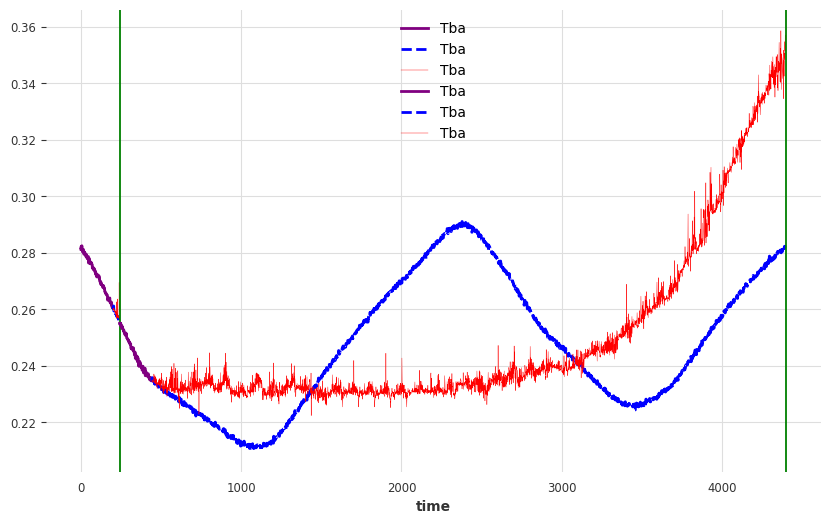

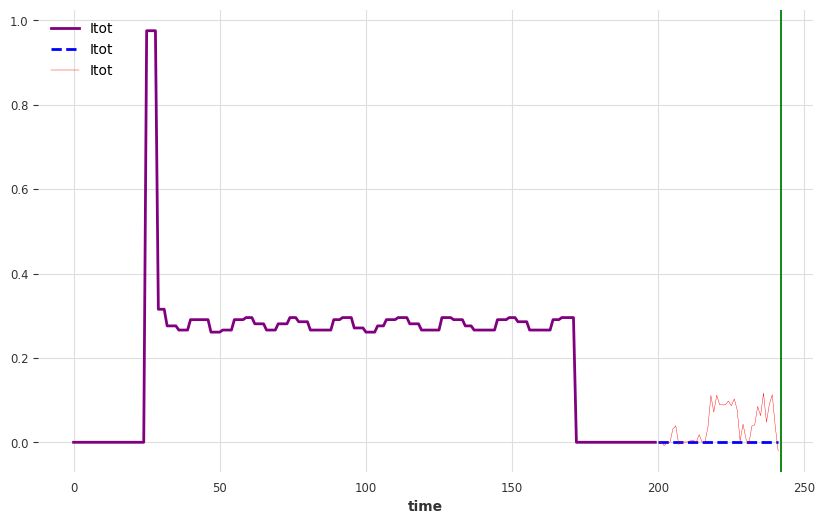

In [36]:
#for attr in attr_list:
    #plt.figure(figsize=(10, 6))
    #vertical_ax_step_at = 0
    
    #for step, p in enumerate(predictions_step_list):
        #vertical_ax_step_at += lengths.values[step]
        #train_step_list[step][attr].plot(color='purple')
        #test_step_list[step][attr].plot(linestyle='dashed', color='blue')
        #p[attr].plot(color = 'red', linewidth=0.5)
        #plt.axvline(x = vertical_ax_step_at, color = 'g')
        #print('STEP:', step+1, "," , attr, 'OPE: ', ope(test_step_list[step][attr], p[attr]))

ope_results = {}  # Dizionario per raccogliere i risultati OPE per ogni attributo

for attr in attr_list:
    ope_results[attr] = []
    plt.figure(figsize=(10, 6))
    vertical_ax_step_at = 0

    for step, p in enumerate(predictions_step_list):
        vertical_ax_step_at += lengths.values[step]
        train_step_list[step][attr].plot(color='purple') #in viola input_per_step
        test_step_list[step][attr].plot(linestyle='dashed', color='blue') #in blu la serie di test reale, con dashed intende tratteggiato
        p[attr].plot(color='red', linewidth=0.3) #in rosso la previsione del modello
        plt.axvline(x=vertical_ax_step_at, color='g')

        ope_value = ope(test_step_list[step][attr], p[attr])
        ope_results[attr].append(ope_value)

# --- (Opzionale) Stampa ben allineata per terminale ---
print("\nTabella OPE:\n")
label_width = 15
step_width = 10

print(" " * label_width + "".join([f"STEP {i+1}".ljust(step_width) for i in range(len(predictions_step_list))]))

#tabella OPE

for attr in attr_list:
    row = attr.ljust(label_width)
    for val in ope_results[attr]:
        val_str = f"{val:.2f}".replace('.', ',')
        row += val_str.ljust(step_width)
    print(row)



In [41]:
import cupy as cp

# Success first 31, failed last 23
df_to_check = 0
input_pred, ground_pred = test[df_to_check]._split_at(0.8)
ic(len(test_speed3[df_to_check]))


# train, test = ts_list_pre[df_to_check].split_after(0.8)[0], ts_list_pre[df_to_check].split_after(0.8)[1] 
prediction = model.predict(
    #n = 1000,
    n=len(ground_per_step), 
    series=input_pred, 
    past_covariates=test_speed3[df_to_check],
    # future_covariates=test_speed3[df_to_check]
    # future_covariates=ts_list_success_speed3_pre[df_to_check]
)


# ts = ts_list_success
# ts.append(scaler.inverse_transform(prediction))


# pred_scaler = Scaler(global_fit=True)
# prediction_pre = pred_scaler.fit_transform(ts)[0]

# prediction_pre = pred_scaler.transform(prediction)
# prediction = scaler.fit_transform(prediction)


ic| len(test_speed3[df_to_check]): 42965
`predict()` was called with `n > output_chunk_length`: using auto-regression to forecast the values after `output_chunk_length` points. The model will access `(n - output_chunk_length)` future values of your `past_covariates` (relative to the first predicted time step). To hide this warning, set `show_warnings=False`.


ic| len(prediction): 3954
ic| len(input_pred): 34372
ic| len(ground_pred): 8593


Tba OPE - Overall Percentage Error:  18.650871052958923
Itot OPE - Overall Percentage Error:  0.18412408611901443


KeyError: 'Vib_Ant'

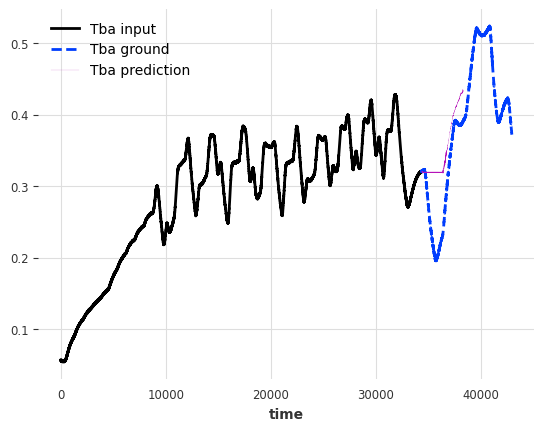

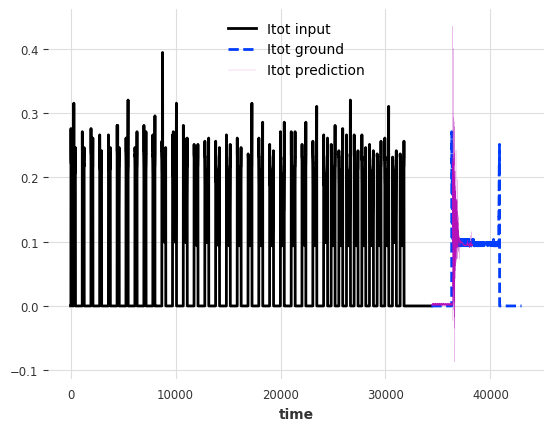

In [42]:
attr_list = ['Tba', 'Itot', 'Vib_Ant', #'Vib_AGG_Lato', 'Vib_AGG_Fondo'
             ]

ic(len(prediction))
ic(len(input_pred))
ic(len(ground_pred))

for attr in attr_list:
    #print(prediction[attr])
    input_pred[attr].plot(label = attr + ' input', new_plot=True)
    ground_pred[attr].plot(label = attr + ' ground', linestyle='dashed')
    prediction[attr].plot(label= attr + ' prediction', linewidth=0.1)
    #print(attr, 'MSE - Mean Squared Error:', mse(test_pred[attr], prediction[attr]))
    #print(attr, 'MAE - Mean Absolute Error:', mae(test_pred[attr], prediction[attr]))
    #print(attr, 'RMSE - Root MSE:', rmse(test_pred[attr], prediction[attr]))
    #print(attr, 'SMAPE- Symmetric Mean Absolute Percentage Error:', smape(test_pred[attr], prediction[attr]))
    #print(attr, 'MASE - Mean Absolute Scaled Error:', mase(test_pred[attr], prediction[attr], train_pred[attr]))
    #print(attr, 'MASE - Mean Absolute Scaled Error:', mase(ground_pred[attr], prediction[attr]))
    print(attr, 'OPE - Overall Percentage Error: ', ope(ground_pred[attr], prediction[attr]))